In [3]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import scipy
import pyDOE
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from net.models import NN
import torch.nn.utils.prune as prune

In [4]:
# 배치학습을 위한 데이터 로더 함수를 정의합니다.
def create_dataloader(x_data, y_data, batch_size, shuffle):
    dataset = TensorDataset(x_data, y_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [5]:
# CUDA 사용 가능한지 확인합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [6]:
models = glob("./data/*_*.pt")
models

['./data/model_0.6461435586370163_0.7519880200471808_1.3459413475493847_.pt',
 './data/model_0.9926610113369381_1.0044676920990128_1.0638761184602317_.pt',
 './data/model_0.8056793994939285_1.667088624340879_0.6558453062090482_.pt',
 './data/model_1.0113005341300303_1.1042978763708164_0.9825942665038673_.pt',
 './data/model_1.3793156162463651_1.4235602716612665_0.5256465964473_.pt',
 './data/model_1.1550933504346717_1.3479038854802354_1.2269056767996454_.pt',
 './data/model_0.6964663563181073_0.8714126073073516_0.8858933764210435_.pt',
 './data/model_0.7807992483360096_1.2503325654877329_0.6434790402413546_.pt',
 './data/model_1.2516291665726755_0.6855972644708601_1.1553484825375557_.pt',
 './data/model_1.215064271879887_1.033489549337249_1.319033954472093_.pt',
 './data/model_0.882821876481688_0.6111822228604451_0.7286163354114135_.pt',
 './data/model_1.0600509553624107_1.80363778828612_0.8063141203855428_.pt',
 './data/model_0.7170707652711635_1.2481880765132585_1.5748870026040955_.p

In [7]:
# 하이퍼 파라미터
batch_size = 5000
shuffle = True # 데이터 셔플
epochs = 2000   # 훈련 epoch
alpha=0.5      # Total Loss = Data Loss + alpha * PDE Loss

# Pruning with L1 norm, amount=0.2

In [8]:
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        if 'mask' in name:
            continue
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
A: 0.6461435586370163 	B: 0.7519880200471808 	C: 1.3459413475493847
Before pruning MSE Loss :  0.051921863
fc1.weight           | nonzeros =      40 /      40 (100.00%) | total_pruned =       0 | shape = (20, 2)
fc1.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc2.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc2.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc3.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc3.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc4.weight           | nonzeros =     400 /     400 (10

/tmp/ipykernel_3875/995630175.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_true = torch.tensor(f_true.ravel(), dtype=torch.float).view(-1, 1)


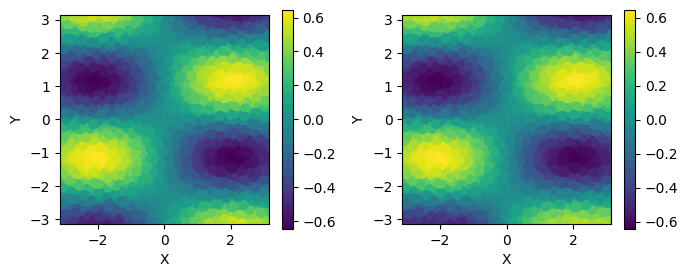

after pruning MSE Loss :  0.051921863
fc1.weight           | nonzeros =      40 /      40 (100.00%) | total_pruned =       0 | shape = (20, 2)
fc1.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc2.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc2.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc3.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc3.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc4.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc4.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc5.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc5.bias             

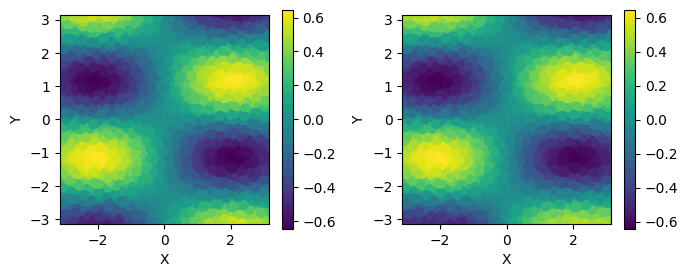

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
A: 0.9926610113369381 	B: 1.0044676920990128 	C: 1.0638761184602317
Before pruning MSE Loss :  0.04581528
fc1.weight           | nonzeros =      40 /      40 (100.00%) | total_pruned =       0 | shape = (20, 2)
fc1.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc2.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc2.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc3.weight           | nonzeros =     400 /     400 (100.00%) | total_pruned =       0 | shape = (20, 20)
fc3.bias             | nonzeros =      20 /      20 (100.00%) | total_pruned =       0 | shape = (20,)
fc4.weight           | nonzeros =     400 /     400 (100

KeyboardInterrupt: 

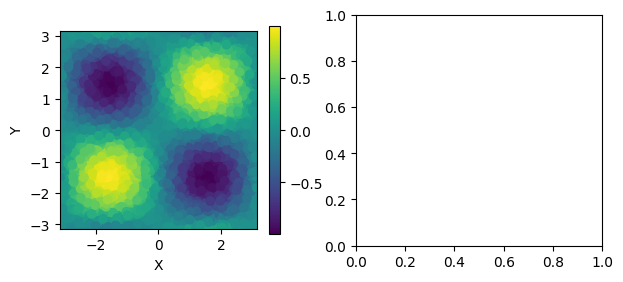

In [11]:
L1_02_before = []
L1_02_after = []

for model in models:
    print("---------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------")
    ABC = model.split("_")[1:4]
    A = torch.tensor(float(ABC[0]), dtype=torch.float)
    B = torch.tensor(float(ABC[1]), dtype=torch.float)
    C = torch.tensor(float(ABC[2]), dtype=torch.float)
    print("A:",ABC[0],"\tB:",ABC[1],"\tC:",ABC[2])
    task = f"./data/train_{ABC[0]}_{ABC[1]}_{ABC[2]}_.npy"
    # 데이터를 준비합니다.
    with open(task, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    f_true = A*np.sin(B*x) * np.sin(C*y)
    X = np.stack([x.ravel(), y.ravel()], axis=-1)
    X = torch.tensor(X, dtype=torch.float).to(device)
    f_true = torch.tensor(f_true.ravel(), dtype=torch.float).view(-1, 1)

    A = A.to(device)
    B = B.to(device)
    C = C.to(device)
    # 데이터 로더를 생성합니다.
    loader = create_dataloader(X, f_true, batch_size, shuffle)


    net = NN(mask=True)
    net.load_state_dict(torch.load(f"./data/model_{ABC[0]}_{ABC[1]}_{ABC[2]}_.pt"))
    net = net.to(device)

    with torch.no_grad():
        f_pred = net(X).cpu().numpy().squeeze()
    
    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1).numpy())-np.square(f_pred))))
    L1_02_before.append(loss)
    print("Before pruning MSE Loss : ", loss)
    print_nonzeros(net)
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():400j, y.min():y.max():400j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    ###### pruning start
    parameters_to_prune = ()
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='mask', amount=0.2)
            prune.remove(module, 'mask')
    
    ##### pruning end
    with torch.no_grad():
        f_pred = net(X).cpu().numpy().squeeze()
    
    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1).numpy())-np.square(f_pred))))
    L1_02_after.append(loss)
    print("after pruning MSE Loss : ", loss)
    print_nonzeros(net)
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():400j, y.min():y.max():400j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()

# Pruning with L1 norm, amount=0.3

A: 0.6461435586370163 	B: 0.7519880200471808 	C: 1.3459413475493847
Before pruning MSE Loss :  0.059730116


/tmp/ipykernel_1624/636197111.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_true = torch.tensor(f_true.ravel(), dtype=torch.float).view(-1, 1)


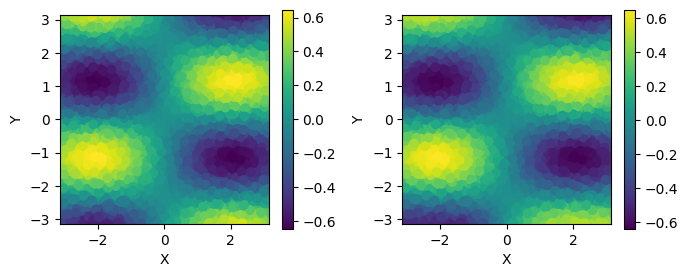

after pruning MSE Loss :  0.1969062


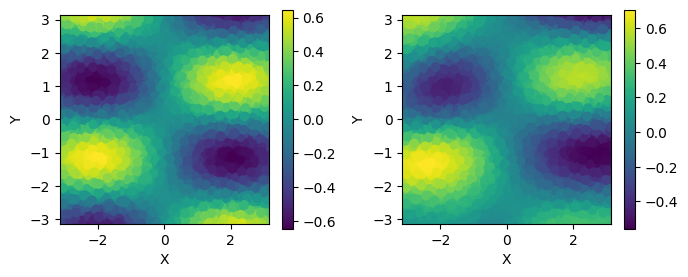

A: 0.9926610113369381 	B: 1.0044676920990128 	C: 1.0638761184602317
Before pruning MSE Loss :  0.046996675


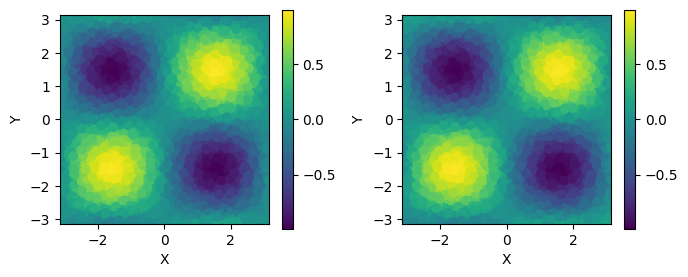

after pruning MSE Loss :  0.54060566


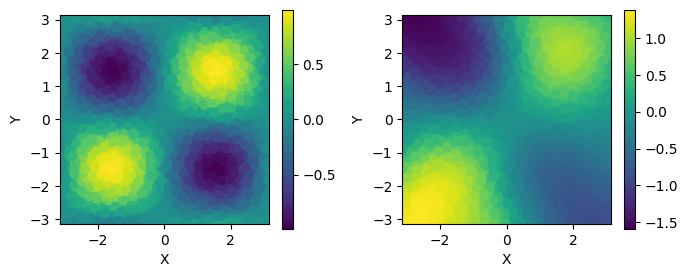

A: 0.8056793994939285 	B: 1.667088624340879 	C: 0.6558453062090482
Before pruning MSE Loss :  0.07396792


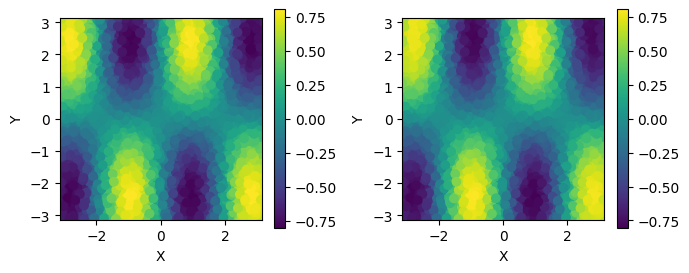

after pruning MSE Loss :  0.4808003


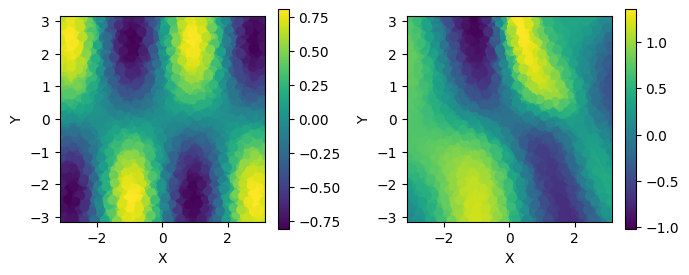

A: 1.0113005341300303 	B: 1.1042978763708164 	C: 0.9825942665038673
Before pruning MSE Loss :  0.064233474


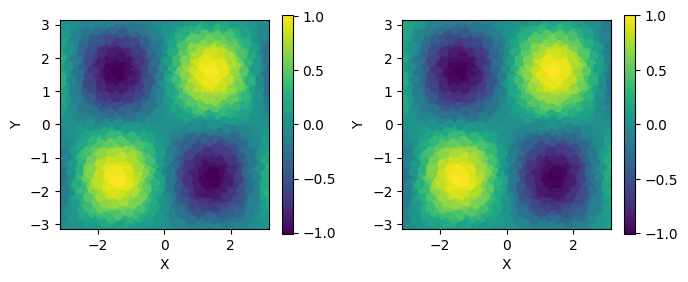

after pruning MSE Loss :  0.339769


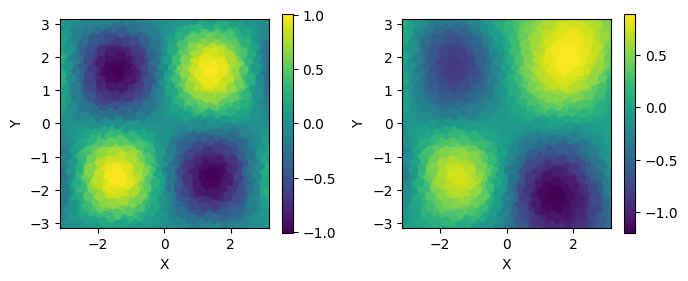

A: 1.3793156162463651 	B: 1.4235602716612665 	C: 0.5256465964473
Before pruning MSE Loss :  0.084103405


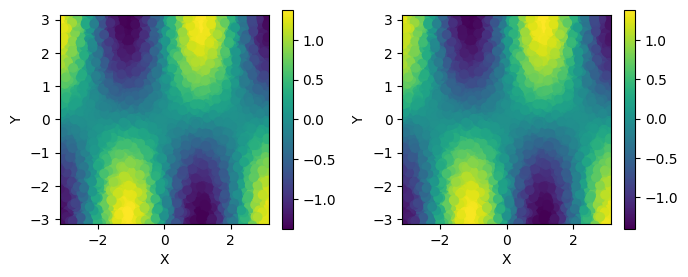

after pruning MSE Loss :  0.6244192


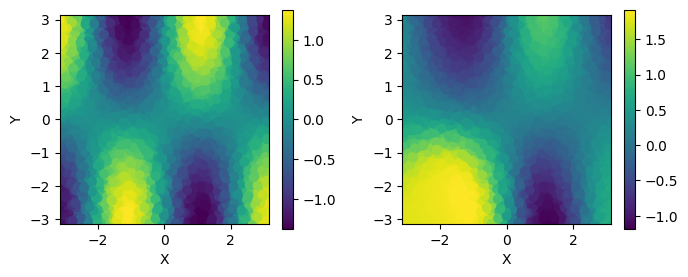

A: 1.1550933504346717 	B: 1.3479038854802354 	C: 1.2269056767996454
Before pruning MSE Loss :  0.1109136


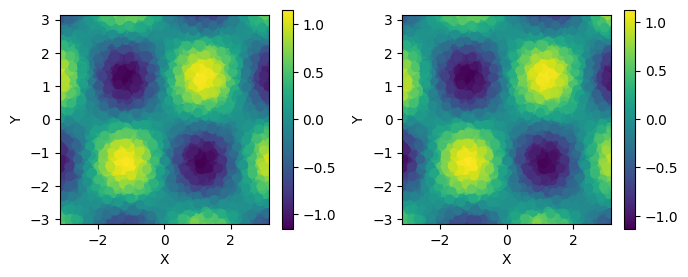

after pruning MSE Loss :  0.7061104


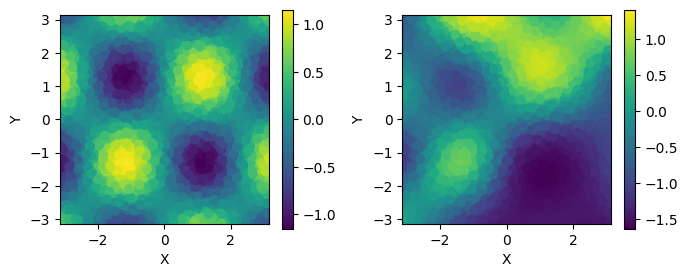

A: 0.6964663563181073 	B: 0.8714126073073516 	C: 0.8858933764210435
Before pruning MSE Loss :  0.027825214


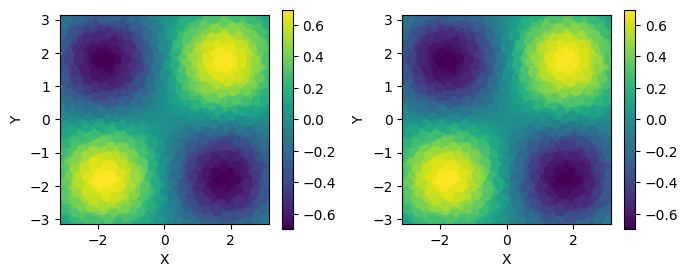

after pruning MSE Loss :  0.2950463


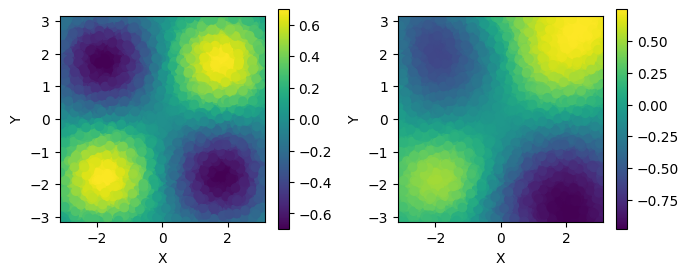

A: 0.7807992483360096 	B: 1.2503325654877329 	C: 0.6434790402413546
Before pruning MSE Loss :  0.031785924


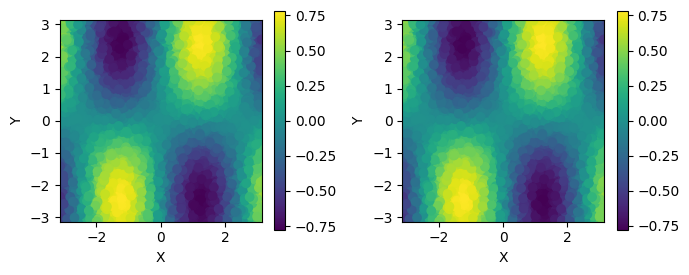

after pruning MSE Loss :  0.30394682


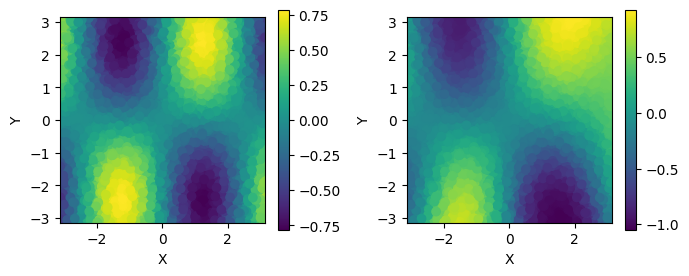

A: 1.2516291665726755 	B: 0.6855972644708601 	C: 1.1553484825375557
Before pruning MSE Loss :  0.055284645


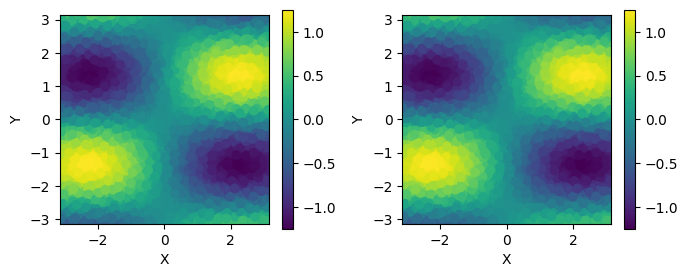

after pruning MSE Loss :  0.46689492


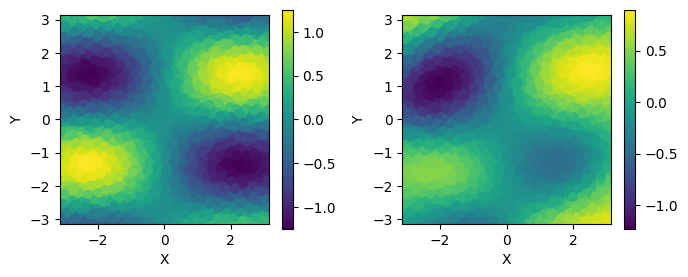

A: 1.215064271879887 	B: 1.033489549337249 	C: 1.319033954472093
Before pruning MSE Loss :  0.07555871


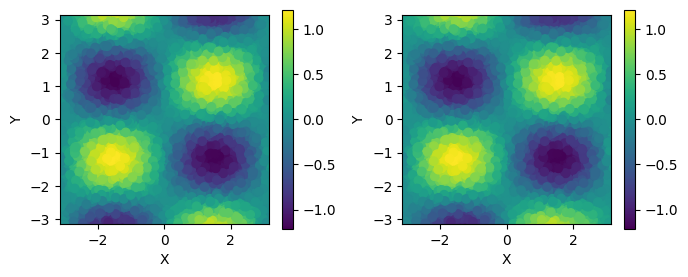

after pruning MSE Loss :  0.4833836


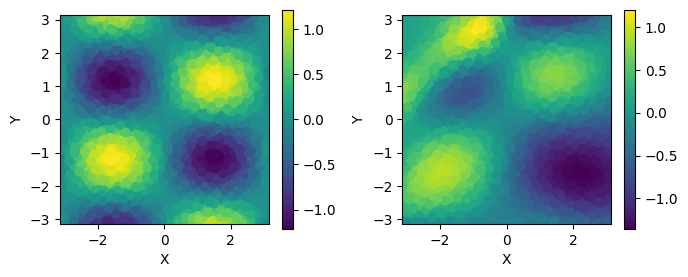

A: 0.882821876481688 	B: 0.6111822228604451 	C: 0.7286163354114135
Before pruning MSE Loss :  0.123876736


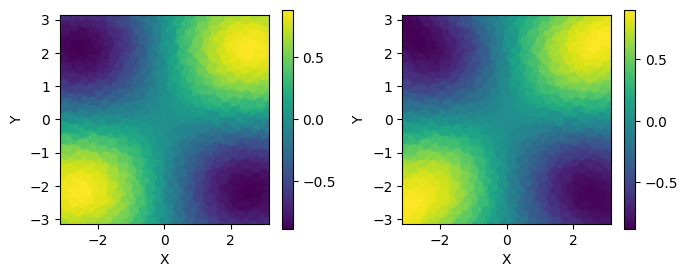

after pruning MSE Loss :  0.30581102


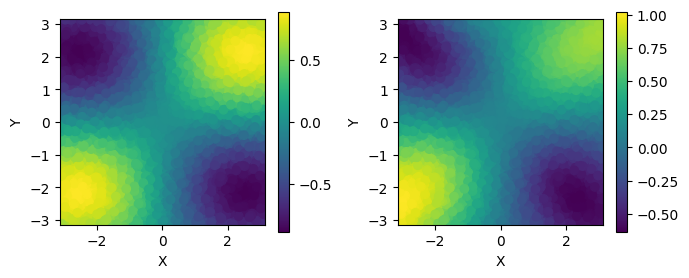

A: 1.0600509553624107 	B: 1.80363778828612 	C: 0.8063141203855428
Before pruning MSE Loss :  0.09682858


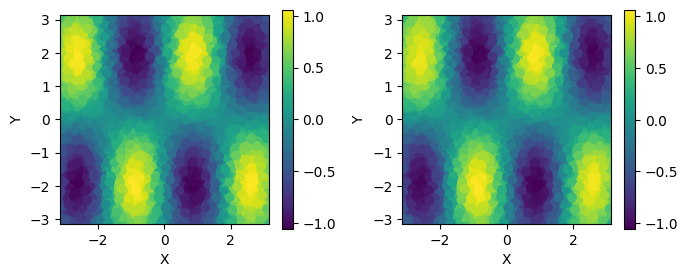

after pruning MSE Loss :  0.52781445


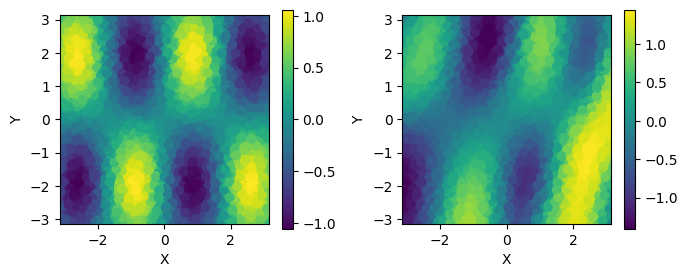

A: 0.7170707652711635 	B: 1.2481880765132585 	C: 1.5748870026040955
Before pruning MSE Loss :  0.16501263


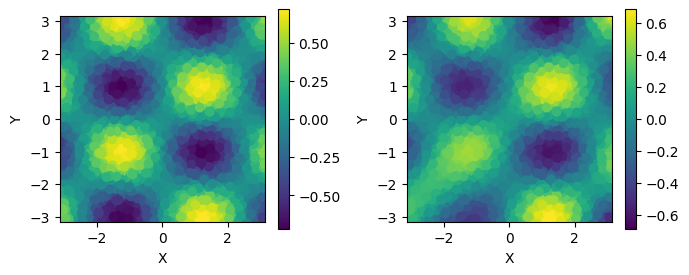

after pruning MSE Loss :  0.4215711


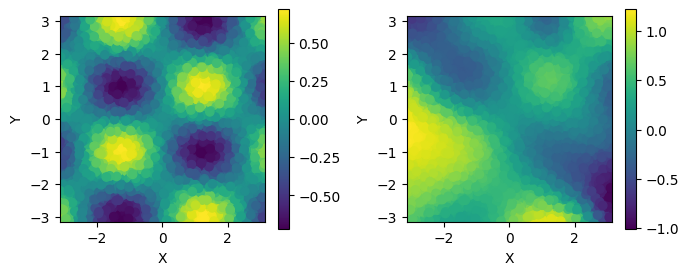

A: 1.3027367182262846 	B: 0.5521091050706922 	C: 1.4942715403090903
Before pruning MSE Loss :  0.069285415


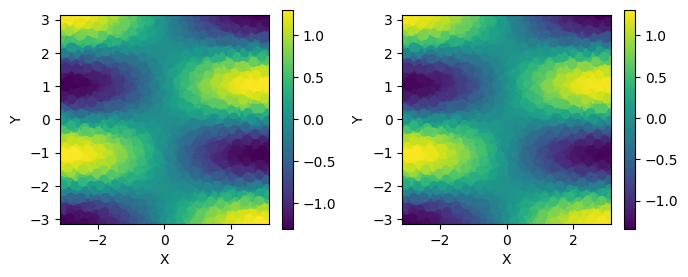

after pruning MSE Loss :  0.48463866


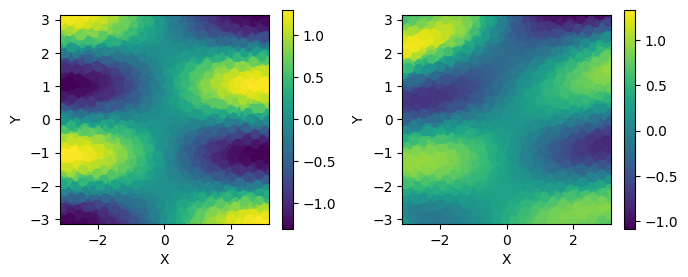

A: 1.4414725726351811 	B: 0.9122516777264776 	C: 1.405664910808274
Before pruning MSE Loss :  0.10572543


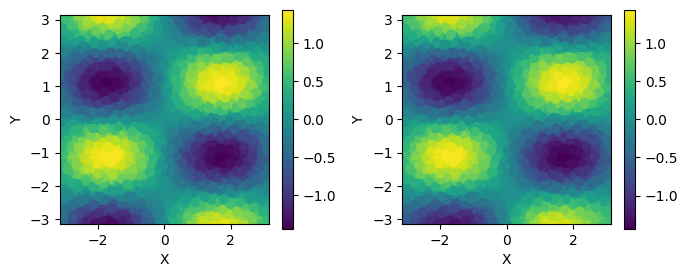

after pruning MSE Loss :  0.66273576


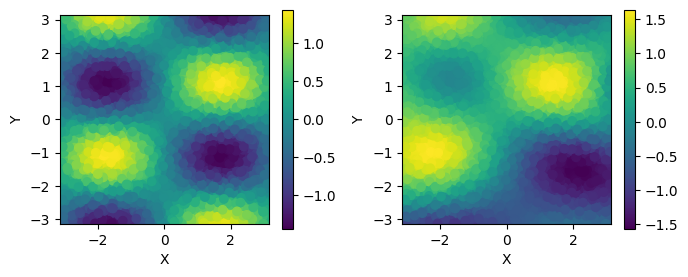

In [38]:
L1_03_before = []
L1_03_after = []

for model in models:
    ABC = model.split("_")[1:4]
    A = torch.tensor(float(ABC[0]), dtype=torch.float)
    B = torch.tensor(float(ABC[1]), dtype=torch.float)
    C = torch.tensor(float(ABC[2]), dtype=torch.float)
    print("A:",ABC[0],"\tB:",ABC[1],"\tC:",ABC[2])
    task = f"./data/train_{ABC[0]}_{ABC[1]}_{ABC[2]}_.npy"
    # 데이터를 준비합니다.
    with open(task, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    f_true = A*np.sin(B*x) * np.sin(C*y)
    X = np.stack([x.ravel(), y.ravel()], axis=-1)
    X = torch.tensor(X, dtype=torch.float).to(device)
    f_true = torch.tensor(f_true.ravel(), dtype=torch.float).view(-1, 1)

    A = A.to(device)
    B = B.to(device)
    C = C.to(device)
    # 데이터 로더를 생성합니다.
    loader = create_dataloader(X, f_true, batch_size, shuffle)


    net = NN()
    net.load_state_dict(torch.load(f"./data/model_{ABC[0]}_{ABC[1]}_{ABC[2]}_.pt"))
    net = net.to(device)

    with torch.no_grad():
        f_pred = net(X).cpu().numpy().squeeze()
    
    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1).numpy())-np.square(f_pred))))
    L1_03_before.append(loss)
    print("Before pruning MSE Loss : ", loss)
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():400j, y.min():y.max():400j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    ###### pruning start
    parameters_to_prune = ()
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=0.3)
            prune.remove(module, 'weight')
    
    ##### pruning end
    with torch.no_grad():
        f_pred = net(X).cpu().numpy().squeeze()
    
    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1).numpy())-np.square(f_pred))))
    L1_03_after.append(loss)
    print("after pruning MSE Loss : ", loss)
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():400j, y.min():y.max():400j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()

# Pruning L1 norm, amount=0.4

A: 0.6461435586370163 	B: 0.7519880200471808 	C: 1.3459413475493847
Before pruning MSE Loss :  0.059730116


/tmp/ipykernel_1624/2342544957.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_true = torch.tensor(f_true.ravel(), dtype=torch.float).view(-1, 1)


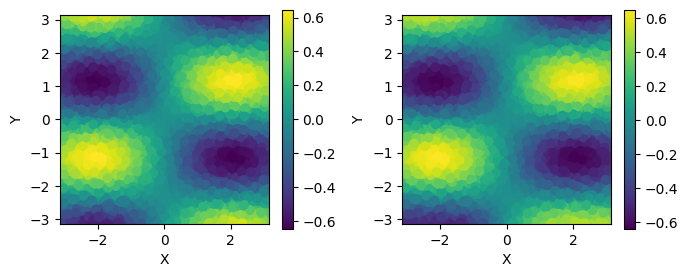

after pruning MSE Loss :  0.37033308


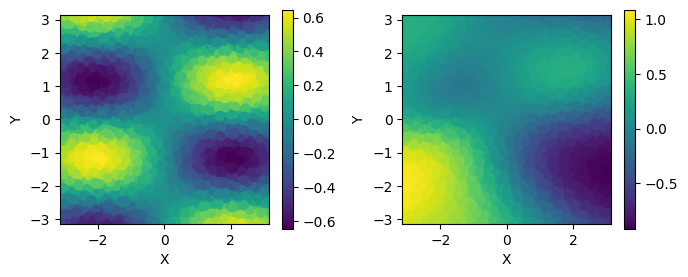

A: 0.9926610113369381 	B: 1.0044676920990128 	C: 1.0638761184602317
Before pruning MSE Loss :  0.046996675


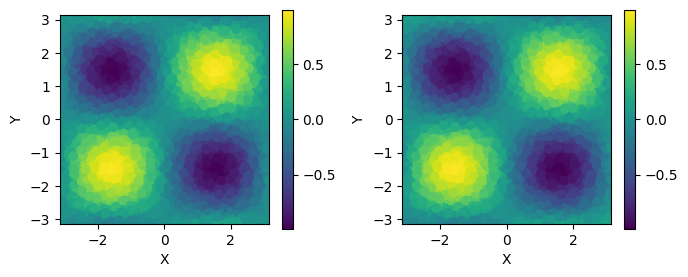

after pruning MSE Loss :  0.50610757


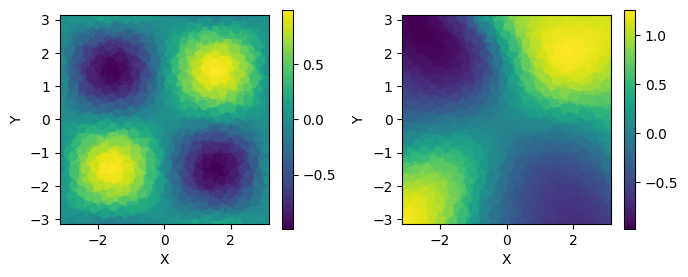

A: 0.8056793994939285 	B: 1.667088624340879 	C: 0.6558453062090482
Before pruning MSE Loss :  0.07396792


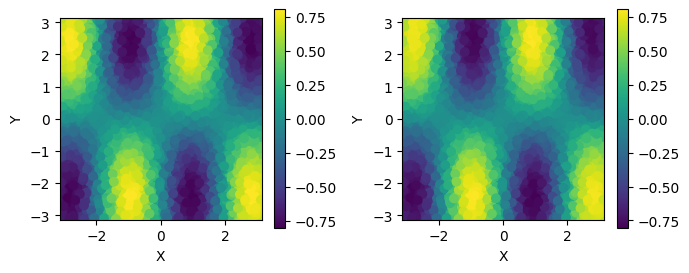

after pruning MSE Loss :  0.55083513


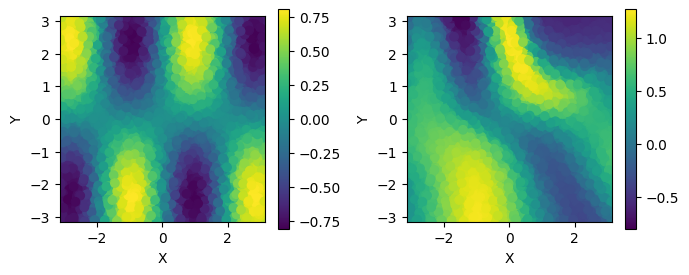

A: 1.0113005341300303 	B: 1.1042978763708164 	C: 0.9825942665038673
Before pruning MSE Loss :  0.064233474


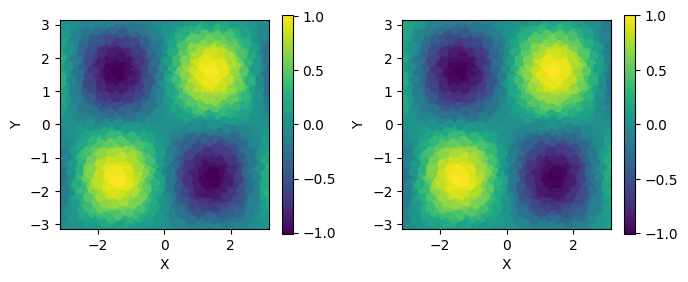

after pruning MSE Loss :  0.50960845


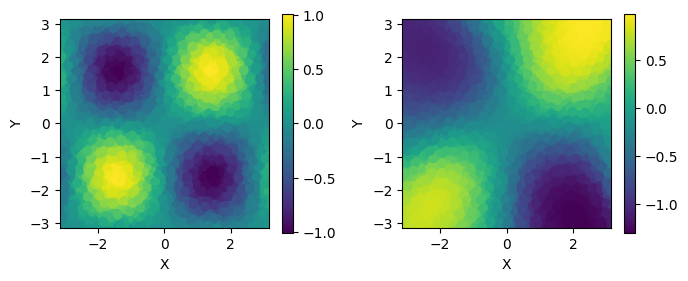

A: 1.3793156162463651 	B: 1.4235602716612665 	C: 0.5256465964473
Before pruning MSE Loss :  0.084103405


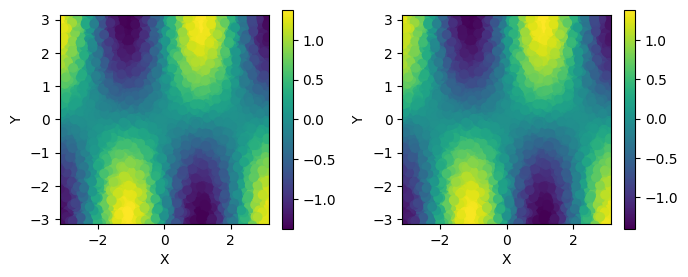

after pruning MSE Loss :  0.5426999


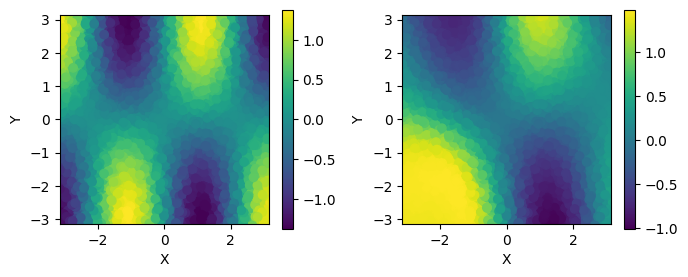

A: 1.1550933504346717 	B: 1.3479038854802354 	C: 1.2269056767996454
Before pruning MSE Loss :  0.1109136


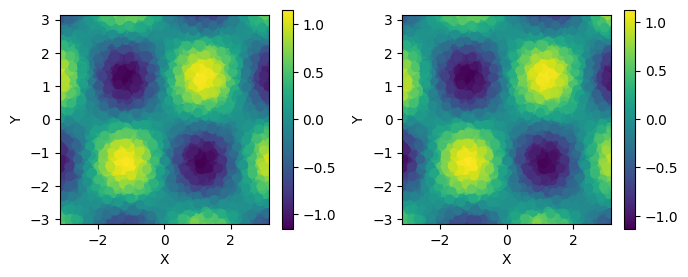

after pruning MSE Loss :  0.6587353


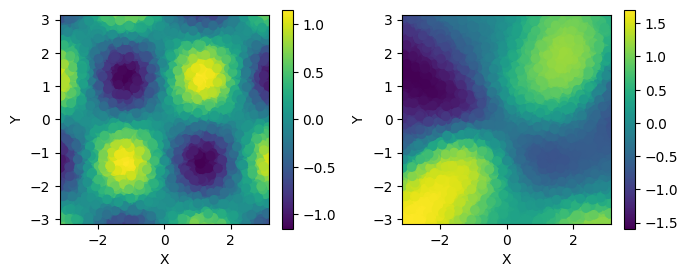

A: 0.6964663563181073 	B: 0.8714126073073516 	C: 0.8858933764210435
Before pruning MSE Loss :  0.027825214


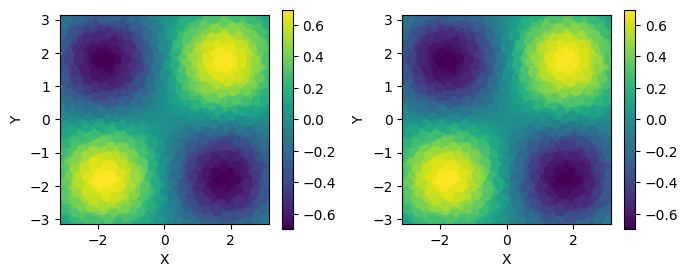

after pruning MSE Loss :  0.29444838


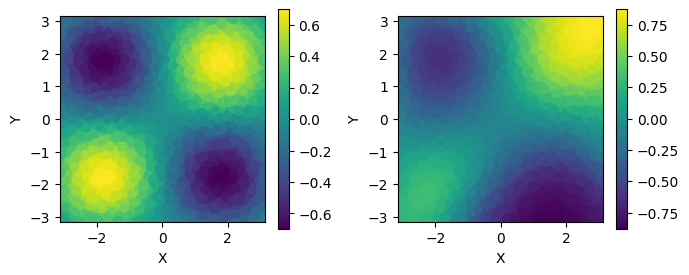

A: 0.7807992483360096 	B: 1.2503325654877329 	C: 0.6434790402413546
Before pruning MSE Loss :  0.031785924


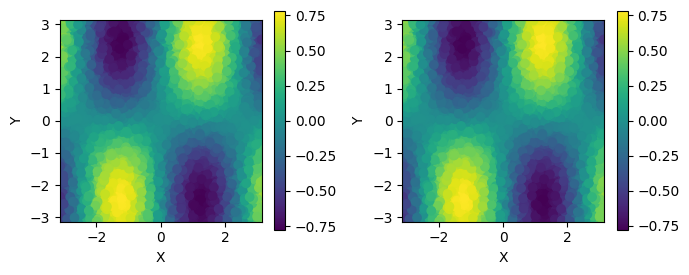

after pruning MSE Loss :  0.37392575


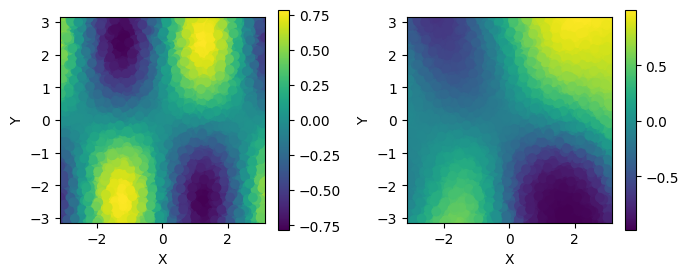

A: 1.2516291665726755 	B: 0.6855972644708601 	C: 1.1553484825375557
Before pruning MSE Loss :  0.055284645


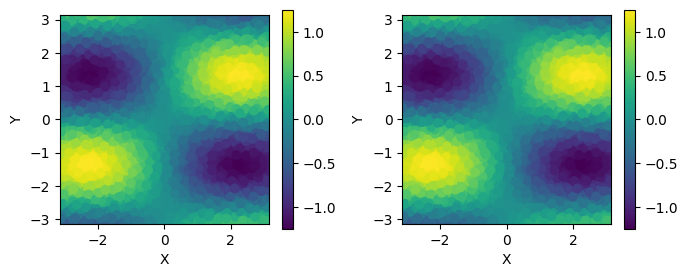

after pruning MSE Loss :  0.5331506


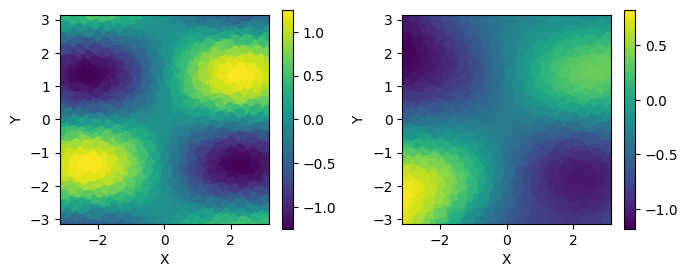

A: 1.215064271879887 	B: 1.033489549337249 	C: 1.319033954472093
Before pruning MSE Loss :  0.07555871


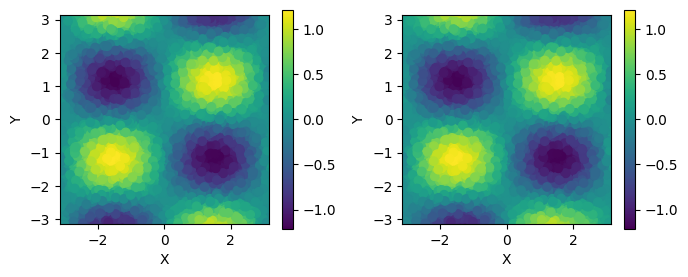

after pruning MSE Loss :  0.49985504


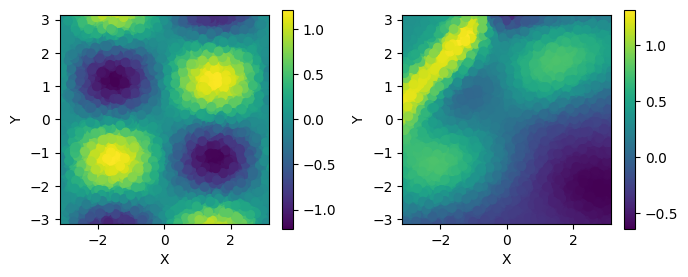

A: 0.882821876481688 	B: 0.6111822228604451 	C: 0.7286163354114135
Before pruning MSE Loss :  0.123876736


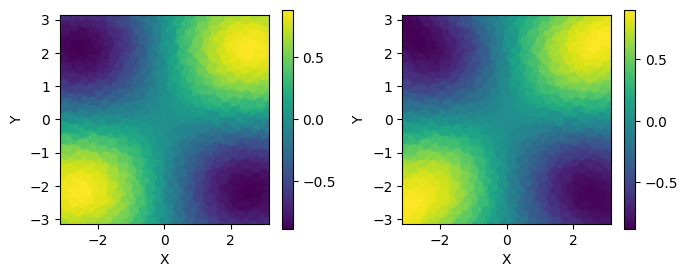

after pruning MSE Loss :  0.34008542


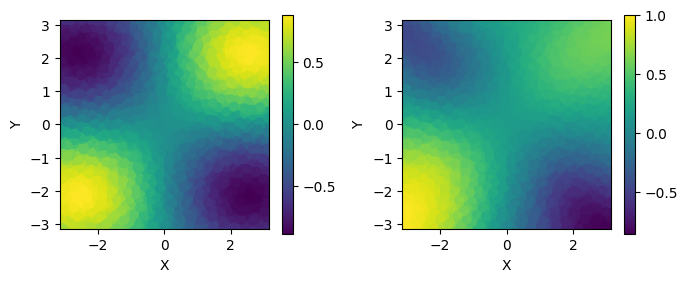

A: 1.0600509553624107 	B: 1.80363778828612 	C: 0.8063141203855428
Before pruning MSE Loss :  0.09682858


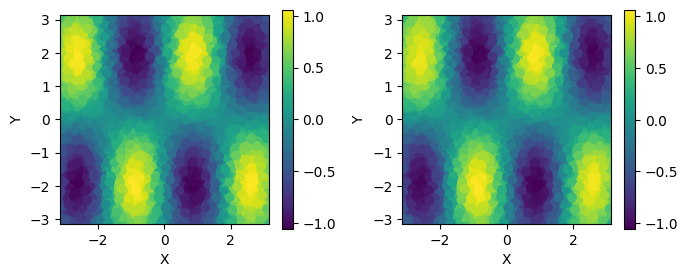

after pruning MSE Loss :  0.53235066


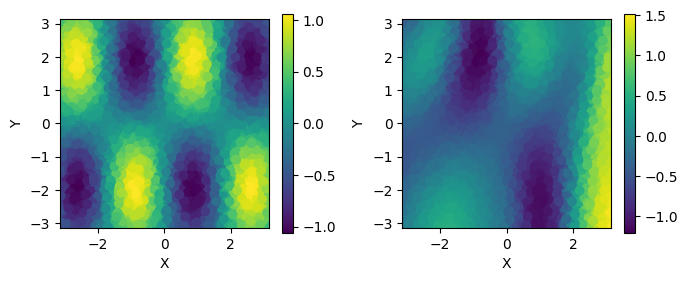

A: 0.7170707652711635 	B: 1.2481880765132585 	C: 1.5748870026040955
Before pruning MSE Loss :  0.16501263


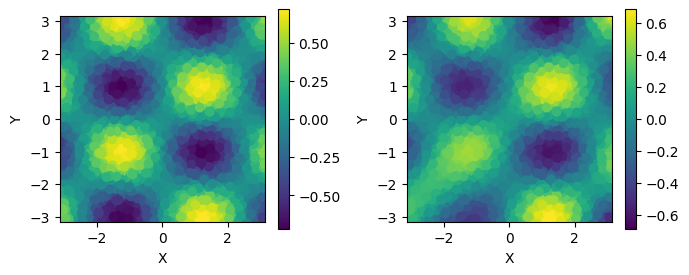

after pruning MSE Loss :  0.49577236


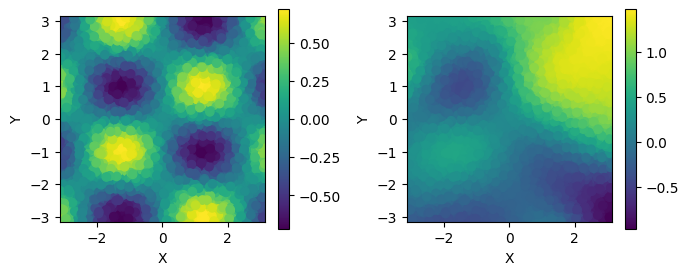

A: 1.3027367182262846 	B: 0.5521091050706922 	C: 1.4942715403090903
Before pruning MSE Loss :  0.069285415


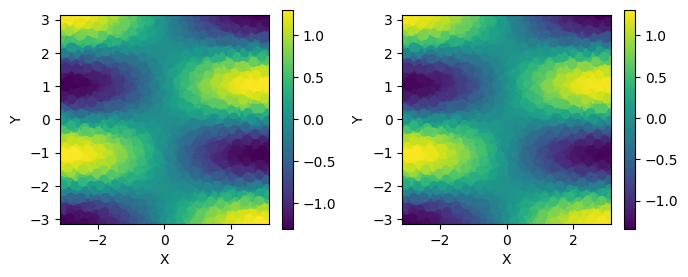

after pruning MSE Loss :  0.50499797


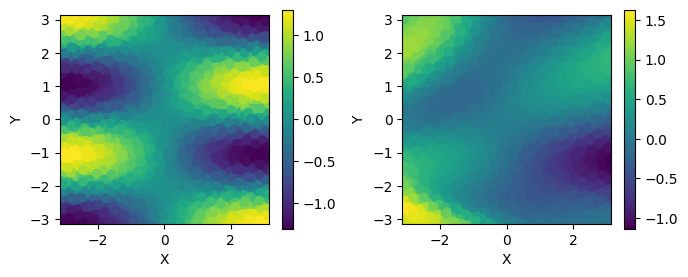

A: 1.4414725726351811 	B: 0.9122516777264776 	C: 1.405664910808274
Before pruning MSE Loss :  0.10572543


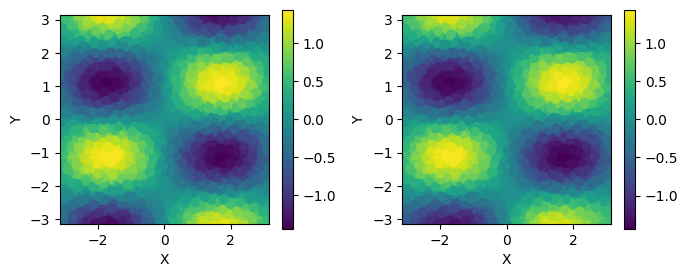

after pruning MSE Loss :  0.57332754


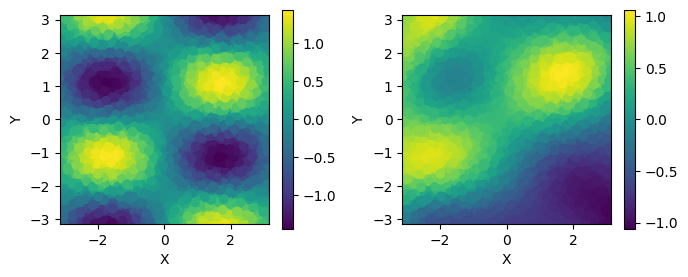

In [37]:
L1_04_before = []
L1_04_after = []

for model in models:
    ABC = model.split("_")[1:4]
    A = torch.tensor(float(ABC[0]), dtype=torch.float)
    B = torch.tensor(float(ABC[1]), dtype=torch.float)
    C = torch.tensor(float(ABC[2]), dtype=torch.float)
    print("A:",ABC[0],"\tB:",ABC[1],"\tC:",ABC[2])
    task = f"./data/train_{ABC[0]}_{ABC[1]}_{ABC[2]}_.npy"
    # 데이터를 준비합니다.
    with open(task, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    f_true = A*np.sin(B*x) * np.sin(C*y)
    X = np.stack([x.ravel(), y.ravel()], axis=-1)
    X = torch.tensor(X, dtype=torch.float).to(device)
    f_true = torch.tensor(f_true.ravel(), dtype=torch.float).view(-1, 1)

    A = A.to(device)
    B = B.to(device)
    C = C.to(device)
    # 데이터 로더를 생성합니다.
    loader = create_dataloader(X, f_true, batch_size, shuffle)


    net = NN()
    net.load_state_dict(torch.load(f"./data/model_{ABC[0]}_{ABC[1]}_{ABC[2]}_.pt"))
    net = net.to(device)

    with torch.no_grad():
        f_pred = net(X).cpu().numpy().squeeze()
    
    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1).numpy())-np.square(f_pred))))
    L1_03_before.append(loss)
    print("Before pruning MSE Loss : ", loss)
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():400j, y.min():y.max():400j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    ###### pruning start
    parameters_to_prune = ()
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=0.4)
            prune.remove(module, 'weight')
    
    ##### pruning end
    with torch.no_grad():
        f_pred = net(X).cpu().numpy().squeeze()
    
    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1).numpy())-np.square(f_pred))))
    L1_03_after.append(loss)
    print("after pruning MSE Loss : ", loss)
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():400j, y.min():y.max():400j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()